In [1]:
import copy
import torch
import argparse
import numpy as np
import umap
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score as nmi, f1_score, roc_auc_score, roc_curve, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from pytorch_metric_learning import losses, reducers, distances
from scipy.optimize import linear_sum_assignment as linear_assignment

import numbers
import torch.nn as nn
from read_patients import *
# from cac import batch_cac
# from autoencoder import AutoEncoder
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

In [2]:
def get_dataset(DATASET, base_dir):
    if DATASET == "cic":
        Xa = pd.read_csv(base_dir + "/CIC/cic_set_a.csv")
        Xb = pd.read_csv(base_dir + "/CIC/cic_set_b.csv")
        Xc = pd.read_csv(base_dir + "/CIC/cic_set_c.csv")

        ya = Xa['In-hospital_death']
        yb = Xb['In-hospital_death']
        yc = Xc['In-hospital_death']

        Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

        cols = Xa.columns

        scale = StandardScaler()
        Xa = scale.fit_transform(Xa)
        Xb = scale.fit_transform(Xb)
        Xc = scale.fit_transform(Xc)

        Xa = pd.DataFrame(Xa, columns=cols)
        Xb = pd.DataFrame(Xb, columns=cols)
        Xc = pd.DataFrame(Xc, columns=cols)

        Xa = Xa.fillna(0)
        Xb = Xb.fillna(0)
        Xc = Xc.fillna(0)

        X_train = pd.concat([Xa, Xb])
        y_train = pd.concat([ya, yb])

        X_test = Xc
        y_test = yc

        X = pd.concat([X_train, X_test]).to_numpy()
        y = pd.concat([y_train, y_test]).to_numpy()

    elif DATASET == "titanic":
        X_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_train.csv").to_numpy()
        X_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_test.csv").to_numpy()
        y_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_train.csv").to_numpy()
        y_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_test.csv").to_numpy()

        X = np.vstack([X_train, X_test])
        y = np.vstack([y_train, y_test])
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        # X = pd.concat([X_train, X_test]).to_numpy()
        # y = pd.concat([y_train, y_test]).to_numpy()
    
    elif DATASET == "infant":
        X = pd.read_csv(base_dir + "/" + DATASET + "/" + "X.csv").to_numpy()
        y = pd.read_csv(base_dir + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
        y = y.astype(int)
        enc = OneHotEncoder(handle_unknown='ignore')
        X = enc.fit_transform(X).toarray()
    
    elif DATASET == "kidney":
        print("Fetching Kidney Dataset")
        data = get_aki(base_dir)
        X = pd.concat(data,axis=1).T
        columns = X.columns

        data_columns = list(columns[1:90]) + ['y'] # get the columns which have data, not mask
        non_binary_columns = data_columns[:81] # only these columns have non-binary data fit for scaling

        X = X.fillna(0)
        X = X[data_columns]

        y = X['y'].to_numpy().astype(int)
        X = X.drop(columns=['y'])

        scaler = MinMaxScaler()
        X[non_binary_columns] = scaler.fit_transform(np.nan_to_num(X[non_binary_columns]))
        X = X.to_numpy()

    else:
        X = pd.read_csv(base_dir + "/" + DATASET + "/" + "X.csv").to_numpy()
        y = pd.read_csv(base_dir + "/" + DATASET + "/" + "y.csv").to_numpy()
        y1 = []
        for i in range(len(y)):
            y1.append(y[i][0])
        y = np.array(y1)
    return X, y

In [3]:
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class CenterLoss(nn.Module):
    def __init__(self, num_class=10, num_feature=2):
        super(CenterLoss, self).__init__()
        self.num_class = num_class
        self.num_feature = num_feature
        self.centers = nn.Parameter(torch.randn(self.num_class, self.num_feature))

    def forward(self, x, labels):
        center = self.centers[labels]
        dist = (x-center).pow(2).sum(dim=-1)
        loss = torch.clamp(dist, min=1e-12, max=1e+12).mean(dim=-1)
        return loss

class Model(nn.Module):
    def __init__(self, args):
        super(Model, self).__init__()
        self.args = args
        self.input_dim = args.input_dim
        self.output_dim = self.input_dim
        self.n_classes = args.n_classes
        self.n_clusters = args.n_clusters
        self.latent_dim = args.latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(args.input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, args.input_dim)
        )
        self.classifiers = []
        for _ in range(self.n_clusters):
            self.classifiers.append(nn.Sequential(
                nn.Linear(self.latent_dim, 8),
                nn.ReLU(),
                nn.Linear(8, 4),
                nn.ReLU(),
                nn.Linear(4, args.n_classes)
            ))
        self.gate = nn.Sequential(
            nn.Linear(self.latent_dim, self.n_clusters),
            nn.Softmax(dim=1)
        )
        
        
    def forward(self, inputs, output="latent"):
        x = self.encoder(inputs)
        if output == "latent":
            return x
        else:
            outs = []
            for i in range(self.n_clusters):
                outs.append(self.classifiers[i](x))
            return self.gate(x), self.decoder(x), outs

In [4]:
def evaluate(model, test_loader):
    X_test = []
    y_test = []
    y_pred = []
    y_classifier_pred = []
    y_classifier_pred_proba = []

    for data, target in test_loader:
        batch_size = data.size()[0]
        X_test.append(data)
        data = data.view(batch_size, -1).to(model.device)
        
        with torch.no_grad():
            latent_X = model.autoencoder(data, latent=True)
            latent_X = latent_X.detach().to(model.device).numpy()

        y_test.append(target.view(-1, 1).numpy())
    
    X_test = torch.vstack(X_test)
    latent_X = model.autoencoder(X_test, latent=True)
    X_test = latent_X.detach().to(model.device).numpy()
    y_test = np.vstack(y_test).reshape(-1)
    y_pred = model.clustering.update_assign(X_test, target).reshape(-1)
    nmi, ari = normalized_mutual_info_score(y_test, y_pred), adjusted_rand_score(y_test, y_pred)

    if model.clustering == "cac":
        base_f1 = f1_score(y_test, model.base_classifier[-1].predict(X_test))
        base_mcc = mcc(y_test, model.base_classifier[-1].predict(X_test))
        base_auc = roc_auc_score(y_test, model.base_classifier[-1].predict_proba(X_test)[:,1])

        X_cluster_test = []
        y_cluster_test = []

        for j in range(model.args.n_clusters):
            cluster_index = np.where(y_pred == j)[0]
            X_cluster = X_test[cluster_index]
            y_cluster = y_test[cluster_index]

            X_cluster_test.append(X_cluster)
            y_cluster_test.extend(y_cluster)

            # Select the cluster classifiers appearing in the latest iteration
            y_classifier_pred.extend(model.cluster_classifiers[-1][j].predict(X_cluster))
            y_classifier_pred_proba.extend(model.cluster_classifiers[-1][j].predict_proba(X_cluster)[:,1])

        cac_f1 = f1_score(y_cluster_test, y_classifier_pred)
        cac_mcc = mcc(y_cluster_test, y_classifier_pred)
        cac_auc = roc_auc_score(y_test, y_classifier_pred_proba)

        return (nmi, ari, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc)
    else:
        return (nmi, ari)
    
def solver(args, model, X_train, train_loader, test_loader):
    rec_loss_list = model.pretrain(train_loader, epoch=args.pre_epoch)
    nmi_list = []
    ari_list = []

    for e in range(args.epoch):
        model.train()
        model.fit(e, train_loader)
        
        model.eval()
        out = evaluate(model, test_loader)  # evaluation on the test_loader
        if len(out) > 2:
            NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
                e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))
        else:
            NMI, ARI = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(e+1, NMI, ARI))

        nmi_list.append(NMI)
        ari_list.append(ARI)
        
        
    return rec_loss_list, nmi_list, ari_list

def create_imbalanced_data_clusters(n_samples=1000, n_features=8, n_informative=5, n_classes=2,\
                            n_clusters = 2, frac=0.4, outer_class_sep=0.5, inner_class_sep=0.2, clus_per_class=2, seed=0):
    np.random.seed(seed)
    X = np.empty(shape=n_features)
    Y = np.empty(shape=1)
    offsets = np.random.normal(0, outer_class_sep, size=(n_clusters, n_features))
    for i in range(n_clusters):
        samples = int(np.random.normal(n_samples, n_samples/10))
        x, y = make_classification(n_samples=samples, n_features=n_features, n_informative=n_informative,\
                                    n_classes=n_classes, class_sep=inner_class_sep, n_clusters_per_class=clus_per_class)
                                    # n_repeated=0, n_redundant=0)
        x += offsets[i]
        y_0 = np.where(y == 0)[0]
        y_1 = np.where(y != 0)[0]
        y_1 = np.random.choice(y_1, int(np.random.normal(frac, frac/4)*len(y_1)))
        index = np.hstack([y_0,y_1])
        np.random.shuffle(index)
        x_new = x[index]
        y_new = y[index]

        X = np.vstack((X,x_new))
        Y = np.hstack((Y,y_new))

    X = pd.DataFrame(X[1:,:])
    Y = Y[1:]
    return X, np.array(Y).astype('int')


In [5]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'cic',

# Training parameters
'lr' : 0.002,
'alpha' : 0,
'wd' : 5e-4,
'batch_size' : 1024,
'epoch' : 15,
'pre_epoch' : 20,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",

# Model parameters
'lamda' : 0.005,
'beta' : 0.00001,
'hidden_dims' : [500, 500, 2000],
'latent_dim' : 20,
'n_clusters' : 2,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 10}

class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.epoch = params['epoch']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = params['latent_dim']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes',\
            'cic', 'sepsis', 'synthetic', 'new_synthetic', 'infant', 'kidney', 'wid_mortality']

In [6]:
if args.dataset in datasets:
    base_dir = "/Users/shivin/Document/NUS/Research/Data"
    print("Loading Dataset:", args.dataset)
    if args.dataset != "kidney":
        if args.dataset == "synthetic":
            n_feat = 45
            X, y = create_imbalanced_data_clusters(n_samples=5000,\
                   n_clusters=args.n_clusters, n_features = n_feat,\
                   inner_class_sep=0.2, outer_class_sep=2, seed=0)
            args.input_dim = n_feat

        elif args.dataset == "paper_synthetic":
            n_feat = 100
            X, y = paper_synthetic(10000)
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
            args.input_dim = n_feat

        else:
            X, y = get_dataset(args.dataset, base_dir)
            print(args.dataset)
            args.input_dim = X.shape[1]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.fit_transform(X_test)
        X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
        X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))

    else:
        print("Loading Kidney Train")
        X_train, y_train = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/aki/train")
        args.input_dim = X_train.shape[1]

        print("Loading Kidney Test")
        X_test, y_test = get_dataset(args.dataset, "/Users/shivin/Document/NUS/Research/Data/aki/test")

        X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
        X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))

        
    train_loader = torch.utils.data.DataLoader(X_train_data_loader,
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
        batch_size=args.batch_size, shuffle=False)

elif args.dir == "../datasets/mnist":
    # Load data
    transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),
                                                           (0.3081,))])

    train_set = datasets.MNIST(args.dir, train=True, download=True, transform=transformer)
    test_set  = datasets.MNIST(args.dir, train=False, transform=transformer)
    train_limit = list(range(0, len(train_set))) if not args.test_run else list(range(0, 500))    
    test_limit  = list(range(0, len(test_set)))  if not args.test_run else list(range(0, 500))    

    train_loader = torch.utils.data.DataLoader(Subset(train_set, train_limit),
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(Subset(test_set, test_limit), 
        batch_size=args.batch_size, shuffle=False)

Loading Dataset: cic
cic


In [219]:
# y_train = y_train.to_numpy().astype(int)
# y_test = y_test.to_numpy().astype(int)
# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()

## Direct Classification

In [15]:
model = Model(args)
criterion = nn.CrossEntropyLoss(reduction='mean')
# criterion = CenterLoss(num_class=2, num_feature=2)
criterion_rec = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

## AE pretraining

In [16]:
model.train()
device = "cpu"
EPOCHS = 40
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        X_inp = (X_batch + np.random.normal(0, 0.01, size=X_batch.shape)).clone().detach().float()
        gate, X_rec, y_pred_local = model(X_inp, output="decoded")
        y_pred = torch.zeros((len(X_inp), args.n_classes))
        for j in range(args.n_clusters):
            y_pred += gate[:,j].reshape(-1,1)*y_pred_local[j]
        
        acc = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_batch.unsqueeze(1))

        loss_rec = criterion_rec(X_batch, X_rec)
        loss_rec.backward()
        optimizer.step()
        
        epoch_loss += loss_rec.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 1.00033 | Acc: 0.000
Epoch 002: | Loss: 0.96513 | Acc: 0.008
Epoch 003: | Loss: 0.89509 | Acc: 0.106
Epoch 004: | Loss: 0.82974 | Acc: 0.154
Epoch 005: | Loss: 0.78061 | Acc: 0.123
Epoch 006: | Loss: 0.74289 | Acc: 0.055
Epoch 007: | Loss: 0.71331 | Acc: 0.002
Epoch 008: | Loss: 0.68503 | Acc: 0.000
Epoch 009: | Loss: 0.66398 | Acc: 0.003
Epoch 010: | Loss: 0.64725 | Acc: 0.009
Epoch 011: | Loss: 0.63231 | Acc: 0.019
Epoch 012: | Loss: 0.61931 | Acc: 0.029
Epoch 013: | Loss: 0.60674 | Acc: 0.034
Epoch 014: | Loss: 0.59535 | Acc: 0.044
Epoch 015: | Loss: 0.58546 | Acc: 0.046
Epoch 016: | Loss: 0.57475 | Acc: 0.052
Epoch 017: | Loss: 0.56461 | Acc: 0.047
Epoch 018: | Loss: 0.55543 | Acc: 0.049
Epoch 019: | Loss: 0.54460 | Acc: 0.049
Epoch 020: | Loss: 0.53605 | Acc: 0.036
Epoch 021: | Loss: 0.52841 | Acc: 0.030
Epoch 022: | Loss: 0.52012 | Acc: 0.030
Epoch 023: | Loss: 0.51377 | Acc: 0.029
Epoch 024: | Loss: 0.50714 | Acc: 0.027
Epoch 025: | Loss: 0.50039 | Acc: 0.027


## Cluster pretraining

In [17]:
model.train()
device = "cpu"
EPOCHS = 40

km = KMeans(n_clusters=args.n_clusters, random_state=0)
latents_X = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
X_train_clusters = km.fit_predict(latents_X.detach().numpy())

for params in model.encoder.parameters():
    params.requires_grad = False

for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        latents_X_batch = model(X_batch, output="latent")
        x_cluster_labels = km.predict(latents_X_batch.detach().numpy())

        y_cluster_labels = MultiLabelBinarizer().fit_transform(x_cluster_labels.reshape(-1,1))
        optimizer.zero_grad()

        gate, X_rec, y_pred_local = model(X_batch, output="decoded")
        acc = nmi(np.argmax(gate.detach().numpy(), axis=1), x_cluster_labels)
#         print(gate)
#         print(torch.FloatTensor(x_cluster_labels).to(args.device).type(torch.LongTensor))
        loss = criterion(gate, torch.FloatTensor(x_cluster_labels).to(args.device).type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss_rec.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

for params in model.encoder.parameters():
    params.requires_grad = True

Epoch 001: | Loss: 0.44838 | Acc: 0.000
Epoch 002: | Loss: 0.44838 | Acc: 0.000
Epoch 003: | Loss: 0.44838 | Acc: 0.000
Epoch 004: | Loss: 0.44838 | Acc: 0.000
Epoch 005: | Loss: 0.44838 | Acc: 0.000
Epoch 006: | Loss: 0.44838 | Acc: 0.000
Epoch 007: | Loss: 0.44838 | Acc: 0.000
Epoch 008: | Loss: 0.44838 | Acc: 0.000
Epoch 009: | Loss: 0.44838 | Acc: 0.000
Epoch 010: | Loss: 0.44838 | Acc: 0.000
Epoch 011: | Loss: 0.44838 | Acc: 0.000
Epoch 012: | Loss: 0.44838 | Acc: 0.000
Epoch 013: | Loss: 0.44838 | Acc: 0.000
Epoch 014: | Loss: 0.44838 | Acc: 0.000
Epoch 015: | Loss: 0.44838 | Acc: 0.000
Epoch 016: | Loss: 0.44838 | Acc: 0.000
Epoch 017: | Loss: 0.44838 | Acc: 0.000
Epoch 018: | Loss: 0.44838 | Acc: 0.000
Epoch 019: | Loss: 0.44838 | Acc: 0.000
Epoch 020: | Loss: 0.44838 | Acc: 0.000
Epoch 021: | Loss: 0.44838 | Acc: 0.000
Epoch 022: | Loss: 0.44838 | Acc: 0.000
Epoch 023: | Loss: 0.44838 | Acc: 0.000
Epoch 024: | Loss: 0.44838 | Acc: 0.000
Epoch 025: | Loss: 0.44838 | Acc: 0.000


In [18]:
for params in model.encoder.parameters():
    params.requires_grad = True
model.train()
device = "cpu"
EPOCHS = 100
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_f1 = 0
    epoch_auc = 0
    alpha = (1-e/EPOCHS)
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        gate, X_tilde, y_pred_local = model(X_batch, output="decoded")
        X_latent = model(X_batch)
        loss = torch.tensor(0.).to(device)
        loss_rec = torch.tensor(0.).to(device)
        y_pred = torch.zeros((len(X_batch), args.n_classes))

        for j in range(args.n_clusters):
            loss += torch.sum(gate[j].reshape(-1,1)*criterion(y_pred_local[j], y_batch))
            y_pred += gate[:,j].reshape(-1,1)*y_pred_local[j]

#         loss = criterion(y_pred, y_batch)
        loss_rec = 0.4*criterion_rec(X_batch, X_tilde)
        f1 = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_batch.unsqueeze(1))
        auc = roc_auc_score(y_batch.unsqueeze(1), y_pred.detach().numpy()[:,1])
        loss_rec.backward(retain_graph=True)
        loss.backward()
        optimizer.step()
        epoch_loss += (loss+loss_rec).item()
        epoch_f1 += f1.item()
        epoch_auc += auc.item()

    gate, X1, y_pred_local = model(torch.tensor(X_test).to(device).float(), output="decoded")
    y_pred = torch.zeros((len(X1), args.n_classes))
    for j in range(args.n_clusters):
        y_pred += gate[:,j].reshape(-1,1)*y_pred_local[j]

    test_f1 = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_test)
    test_auc = roc_auc_score(y_test, y_pred.detach().numpy()[:,1])
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Train F1: {epoch_f1/len(train_loader):.3f}\
| Train AUC: {epoch_auc/len(train_loader):.3f} | Test F1: {test_f1:.3f} | Test AUC: {test_auc/len(train_loader):.3f}')

Epoch 001: | Loss: 1.53000 | Train F1: 0.011| Train AUC: 0.411 | Test F1: 0.005 | Test AUC: 0.046
Epoch 002: | Loss: 1.41880 | Train F1: 0.005| Train AUC: 0.427 | Test F1: 0.000 | Test AUC: 0.047
Epoch 003: | Loss: 1.37981 | Train F1: 0.003| Train AUC: 0.436 | Test F1: 0.000 | Test AUC: 0.046
Epoch 004: | Loss: 1.35997 | Train F1: 0.006| Train AUC: 0.435 | Test F1: 0.014 | Test AUC: 0.046
Epoch 005: | Loss: 1.34859 | Train F1: 0.018| Train AUC: 0.444 | Test F1: 0.032 | Test AUC: 0.048
Epoch 006: | Loss: 1.34097 | Train F1: 0.042| Train AUC: 0.451 | Test F1: 0.067 | Test AUC: 0.049
Epoch 007: | Loss: 1.33511 | Train F1: 0.078| Train AUC: 0.455 | Test F1: 0.100 | Test AUC: 0.049
Epoch 008: | Loss: 1.33128 | Train F1: 0.116| Train AUC: 0.462 | Test F1: 0.123 | Test AUC: 0.051
Epoch 009: | Loss: 1.32606 | Train F1: 0.158| Train AUC: 0.469 | Test F1: 0.176 | Test AUC: 0.052
Epoch 010: | Loss: 1.32214 | Train F1: 0.208| Train AUC: 0.478 | Test F1: 0.192 | Test AUC: 0.053
Epoch 011: | Loss: 1

Epoch 086: | Loss: 1.01045 | Train F1: 0.769| Train AUC: 0.880 | Test F1: 0.487 | Test AUC: 0.092
Epoch 087: | Loss: 1.01499 | Train F1: 0.774| Train AUC: 0.881 | Test F1: 0.500 | Test AUC: 0.092
Epoch 088: | Loss: 1.01196 | Train F1: 0.774| Train AUC: 0.881 | Test F1: 0.484 | Test AUC: 0.092
Epoch 089: | Loss: 1.00712 | Train F1: 0.774| Train AUC: 0.882 | Test F1: 0.487 | Test AUC: 0.092
Epoch 090: | Loss: 1.00283 | Train F1: 0.777| Train AUC: 0.883 | Test F1: 0.494 | Test AUC: 0.092
Epoch 091: | Loss: 0.99396 | Train F1: 0.781| Train AUC: 0.883 | Test F1: 0.480 | Test AUC: 0.092
Epoch 092: | Loss: 0.99163 | Train F1: 0.780| Train AUC: 0.883 | Test F1: 0.484 | Test AUC: 0.092
Epoch 093: | Loss: 0.99513 | Train F1: 0.782| Train AUC: 0.883 | Test F1: 0.488 | Test AUC: 0.092
Epoch 094: | Loss: 0.99621 | Train F1: 0.786| Train AUC: 0.883 | Test F1: 0.500 | Test AUC: 0.092
Epoch 095: | Loss: 0.99804 | Train F1: 0.788| Train AUC: 0.884 | Test F1: 0.483 | Test AUC: 0.092
Epoch 096: | Loss: 0

In [280]:
reducer = umap.UMAP()
X_train = X_train.astype(float)
gate, X1, preds = model(torch.tensor(X_train).float().to(device), output="decoded")
x_emb_train = reducer.fit_transform(X1.detach().numpy())
x_emb_test = reducer.transform(model(torch.tensor(X_test).float().to(device)).detach().numpy())

In [281]:
print(torch.argmax(gate, axis=1))

tensor([1, 1, 1,  ..., 1, 1, 1])


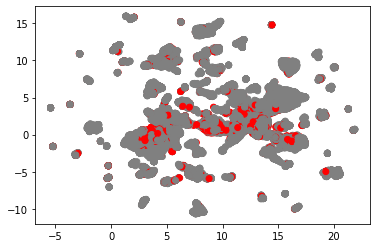

In [282]:
c_clusters = [color[int(y_train[i])] for i in range(len(y_train))]
plt.scatter(x_emb_train[:,0], x_emb_train[:,1], color=c_clusters)

0.0015682068432274758


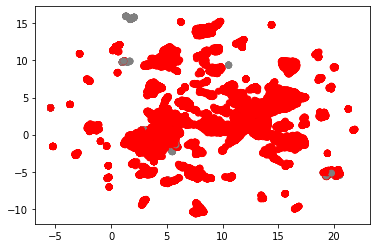

In [283]:
clusters = torch.argmax(gate, axis=1).numpy()
print(nmi(clusters, y_train))
c_clusters = [color[int(clusters[i])] for i in range(len(y_train))]
plt.scatter(x_emb_train[:,0], x_emb_train[:,1], color=c_clusters)

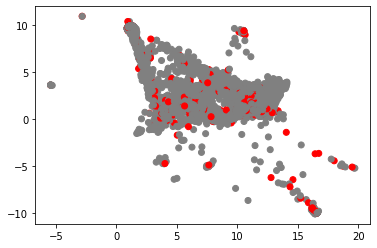

In [284]:
c_clusters = [color[int(y_test[i])] for i in range(len(y_test))]
plt.scatter(x_emb_test[:,0], x_emb_test[:,1], color=c_clusters)

In [230]:
_, X1, y_pred = model(torch.tensor(X_test).to(device).float(), output="decoded")
print("Test F1")
print(f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_test))

Test F1


AttributeError: 'list' object has no attribute 'detach'

## Cluster-then-predict

In [98]:
model = NNClassifier(args)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss(reduction='mean')
# criterion = losses.ContrastiveLoss(reducer=reducers.MeanReducer())
# criterion.get_default_distance = distances.DotProductSimilarity
# criterion = losses.CircleLoss(reducer=red)
# criterion = CenterLoss(2, 2)
criterion_rec = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [99]:
model.train()
device = "cpu"
EPOCHS = 50
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        X_inp = (X_batch + np.random.normal(0, 0.01, size=X_batch.shape)).clone().detach().float()
#         X_inp = X_batch
        X_rec, y_pred = model(X_inp, output="decoded")
        acc = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_batch.unsqueeze(1))

        loss_rec = criterion_rec(X_batch, X_rec)
        loss_rec.backward()
        optimizer.step()
        
        epoch_loss += loss_rec.item()
        epoch_acc += acc.item()
        
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.17149 | Acc: 0.016
Epoch 002: | Loss: 0.06304 | Acc: 0.669
Epoch 003: | Loss: 0.02954 | Acc: 0.627
Epoch 004: | Loss: 0.02621 | Acc: 0.074
Epoch 005: | Loss: 0.02532 | Acc: 0.012
Epoch 006: | Loss: 0.02497 | Acc: 0.014
Epoch 007: | Loss: 0.02479 | Acc: 0.020
Epoch 008: | Loss: 0.02462 | Acc: 0.015
Epoch 009: | Loss: 0.02442 | Acc: 0.005
Epoch 010: | Loss: 0.02406 | Acc: 0.005
Epoch 011: | Loss: 0.02340 | Acc: 0.024
Epoch 012: | Loss: 0.02248 | Acc: 0.123
Epoch 013: | Loss: 0.02143 | Acc: 0.302
Epoch 014: | Loss: 0.02052 | Acc: 0.450
Epoch 015: | Loss: 0.01982 | Acc: 0.527
Epoch 016: | Loss: 0.01908 | Acc: 0.499
Epoch 017: | Loss: 0.01739 | Acc: 0.530
Epoch 018: | Loss: 0.01545 | Acc: 0.546
Epoch 019: | Loss: 0.01476 | Acc: 0.508
Epoch 020: | Loss: 0.01434 | Acc: 0.539
Epoch 021: | Loss: 0.01383 | Acc: 0.577
Epoch 022: | Loss: 0.01313 | Acc: 0.595
Epoch 023: | Loss: 0.01233 | Acc: 0.615
Epoch 024: | Loss: 0.01163 | Acc: 0.618
Epoch 025: | Loss: 0.01116 | Acc: 0.621


In [100]:
model.train()
device = "cpu"
EPOCHS = 70
for e in range(1, EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    alpha = (1-e/EPOCHS)
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        X1, y_pred = model(X_batch, output="decoded")
        X_latent = model(X_batch)
        loss = torch.tensor(0.).to(device)
        loss_rec = torch.tensor(0.).to(device)
        km = KMeans(n_clusters = args.n_clusters)
        clusters = km.fit_predict(X_latent.detach().numpy())

        for j in range(args.n_clusters):
            idx = np.where(clusters == j)[0]
            X_idx = X_latent[idx]
            y_pred_idx = y_pred[idx]
            y_batch_idx = y_batch[idx]
            loss += criterion(y_pred_idx, y_batch_idx)

#         loss = criterion(y_pred, y_batch)
        loss_rec = 0.05*criterion_rec(X_batch, X1)
        loss_rec -= km.score(model(torch.tensor(X_train).float().to(device)).detach().numpy())/len(y_batch)
        acc = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_batch.unsqueeze(1))
        loss_rec.backward(retain_graph=True)
        loss.backward()
        optimizer.step()
        epoch_loss += (loss+loss_rec).item()
        epoch_acc += acc.item()

    X1, y_pred = model(torch.tensor(X_test).to(device).float(), output="decoded")
    test_f1 = f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_test)
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Test Acc: {test_f1:.3f}')

Epoch 001: | Loss: 15.59436 | Acc: 0.626 | Test Acc: 0.690
Epoch 002: | Loss: 21.44003 | Acc: 0.604 | Test Acc: 0.621
Epoch 003: | Loss: 26.15018 | Acc: 0.591 | Test Acc: 0.626
Epoch 004: | Loss: 28.31284 | Acc: 0.577 | Test Acc: 0.662
Epoch 005: | Loss: 28.50289 | Acc: 0.610 | Test Acc: 0.658
Epoch 006: | Loss: 28.34870 | Acc: 0.619 | Test Acc: 0.615
Epoch 007: | Loss: 29.97783 | Acc: 0.633 | Test Acc: 0.642
Epoch 008: | Loss: 29.49347 | Acc: 0.632 | Test Acc: 0.670
Epoch 009: | Loss: 27.62653 | Acc: 0.634 | Test Acc: 0.590
Epoch 010: | Loss: 28.23735 | Acc: 0.633 | Test Acc: 0.663
Epoch 011: | Loss: 30.63279 | Acc: 0.644 | Test Acc: 0.677
Epoch 012: | Loss: 29.28488 | Acc: 0.643 | Test Acc: 0.674
Epoch 013: | Loss: 30.12894 | Acc: 0.654 | Test Acc: 0.666
Epoch 014: | Loss: 30.87373 | Acc: 0.649 | Test Acc: 0.673
Epoch 015: | Loss: 32.01643 | Acc: 0.648 | Test Acc: 0.677
Epoch 016: | Loss: 31.34168 | Acc: 0.648 | Test Acc: 0.671
Epoch 017: | Loss: 32.87184 | Acc: 0.655 | Test Acc: 0.6

In [102]:
reducer = umap.UMAP()
X_train = X_train.astype(float)
x_emb_train = reducer.fit_transform(model(torch.tensor(X_train).float().to(device)).detach().numpy())
x_emb_test = reducer.transform(model(torch.tensor(X_test).float().to(device)).detach().numpy())

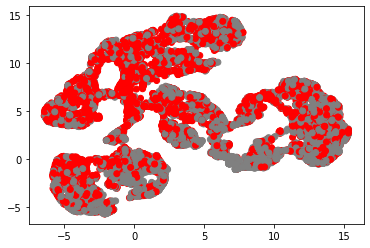

In [103]:
c_clusters = [color[int(y_train[i])] for i in range(len(y_train))]
plt.scatter(x_emb_train[:,0], x_emb_train[:,1], color=c_clusters)

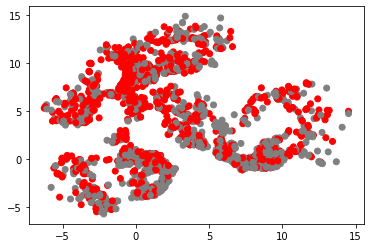

In [104]:
c_clusters = [color[int(y_test[i])] for i in range(len(y_test))]
plt.scatter(x_emb_test[:,0], x_emb_test[:,1], color=c_clusters)

In [105]:
X1, y_pred = model(torch.tensor(X_test).to(device).float(), output="decoded")
print("Test F1")
print(f1_score(np.argmax(y_pred.detach().numpy(), axis=1), y_test))
print(km.score(model(torch.tensor(X_train).float().to(device)).detach().numpy())/len(X_train))

Test F1
0.6655052264808363
-4.4766365366068435


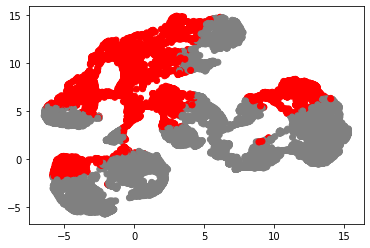

In [106]:
km = KMeans(n_clusters = args.n_clusters)
clusters = km.fit_predict(model(torch.tensor(X_train).float().to(device)).detach().numpy())

c_clusters = [color[int(clusters[i])] for i in range(len(y_train))]
plt.scatter(x_emb_train[:,0], x_emb_train[:,1], color=c_clusters)